<a href="https://colab.research.google.com/github/revinarnan/ASII-prediction-with-LSTM/blob/main/ASII_Price_Prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Muhammad Revin Arnan
## mrevin11@gmail.com

# Dataset Harga Saham ASII (Astra International) sejak 2001

In [ ]:
# Import Library yang dibutuhkan
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
# Buka file dan menjadikan timestamp sebagai index
dataset = '/content/drive/My Drive/ASII.csv'
df = pd.read_csv(dataset)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,open,low,high,close,volume
timestamp,,,,,
2001-04-16,100,98,100,98,26720769
2001-04-17,98,96,98,96,46143469
2001-04-18,96,96,98,98,49430188
2001-04-19,100,94,100,96,171685797
2001-04-20,92,86,92,88,259307923


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5625 entries, 2001-04-16 to 2022-11-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   open    5625 non-null   int64
 1   low     5625 non-null   int64
 2   high    5625 non-null   int64
 3   close   5625 non-null   int64
 4   volume  5625 non-null   int64
dtypes: int64(5)
memory usage: 263.7 KB


In [ ]:
df.isnull().sum()

open      0
low       0
high      0
close     0
volume    0
dtype: int64

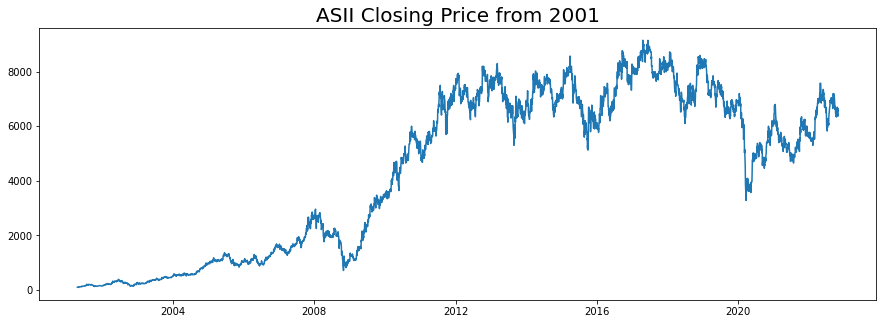

In [ ]:
# Plot Harga Saham ASII dari 2001
plt.figure(figsize=(15,5))
plt.plot(df.index, df['close'])
plt.title('ASII Closing Price from 2001',
          fontsize=20);

# Pre-processing Data

In [ ]:
data = df.drop(['low', 'high', 'volume'], axis=1)
data

,open,close
timestamp,,
2001-04-16,100,98
2001-04-17,98,96
2001-04-18,96,98
2001-04-19,100,96
2001-04-20,92,88
...,...,...
2022-10-31,6550,6650
2022-11-01,6650,6575
2022-11-02,6525,6425


### Normalisasi Data

In [ ]:
# Normalisasi data dengan MinMaxScaler supaya data dalam skala range yang sama
min_max_scaler = MinMaxScaler()
data[['open','close']] = min_max_scaler.fit_transform(data[['open','close']])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5625 entries, 2001-04-16 to 2022-11-04
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5625 non-null   float64
 1   close   5625 non-null   float64
dtypes: float64(2)
memory usage: 131.8 KB


### Split Training and Validation Data

In [ ]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [ ]:
train, test = split_data(data['close'], 0.8)

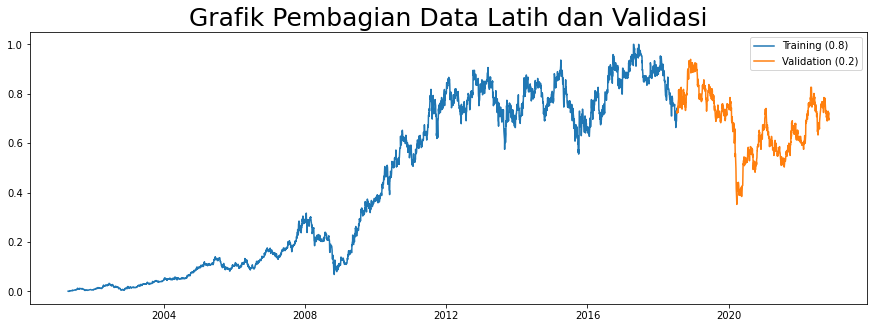

In [ ]:
# Plot pembagian data latih dan validasi
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training (0.8)', 'Validation (0.2)'])
plt.title('Grafik Pembagian Data Latih dan Validasi', fontsize=25)
plt.show()

In [ ]:
def split_target(df, look_back=1):
  X, y = [], []
  for i in range(len(df) - look_back):
    a = df[i:(i + look_back), 0]
    b = df[i + look_back, 0]
    X.append(a)
    y.append(b)
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build & Training Model

In [ ]:
# Build model ML
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, input_shape=(1, 1), return_sequences=True),
  tf.keras.layers.LSTM(96),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.011:
      self.model.stop_training = True

callback = Callback()

In [ ]:
# Training model ML
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[callback])

Epoch 1/2000
36/36 [==============================] - 13s 118ms/step - loss: 0.1374 - mae: 0.4105 - val_loss: 0.2062 - val_mae: 0.6308
Epoch 2/2000
36/36 [==============================] - 1s 34ms/step - loss: 0.1172 - mae: 0.3702 - val_loss: 0.1676 - val_mae: 0.5666
Epoch 3/2000
36/36 [==============================] - 1s 29ms/step - loss: 0.0890 - mae: 0.3223 - val_loss: 0.1126 - val_mae: 0.4607
Epoch 4/2000
36/36 [==============================] - 1s 17ms/step - loss: 0.0582 - mae: 0.2800 - val_loss: 0.0549 - val_mae: 0.3141
Epoch 5/2000
36/36 [==============================] - 1s 17ms/step - loss: 0.0398 - mae: 0.2564 - val_loss: 0.0213 - val_mae: 0.1858
Epoch 6/2000
36/36 [==============================] - 1s 15ms/step - loss: 0.0370 - mae: 0.2509 - val_loss: 0.0111 - val_mae: 0.1279
Epoch 7/2000
36/36 [==============================] - 1s 16ms/step - loss: 0.0355 - mae: 0.2430 - val_loss: 0.0079 - val_mae: 0.1059
Epoch 8/2000
36/36 [==============================] - 1s 16ms/step 

In [ ]:
threshold_mae = (data['close'].max() - data['close'].min()) * 10/100
print("Threshold MAE tidak boleh lebih dari", threshold_mae)

Threshold MAE tidak boleh lebih dari 0.1


In [ ]:
model.evaluate(X_test, y_test)

36/36 [==============================] - 0s 4ms/step - loss: 9.8558e-05 - mae: 0.0106


[9.855801908997819e-05, 0.010583387687802315]

# Plot Loss and MAE

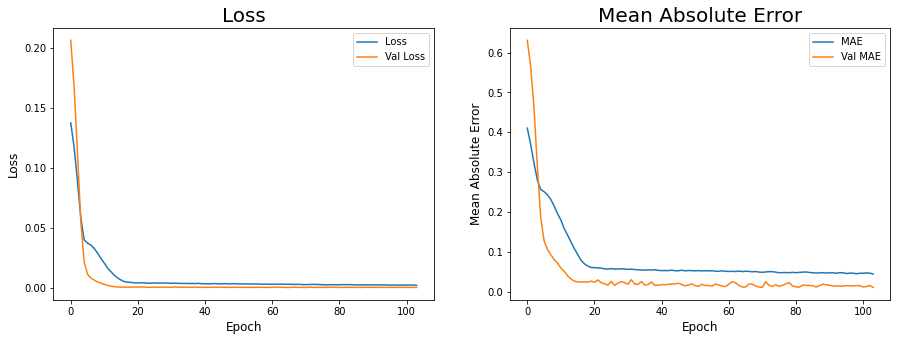

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['MAE','Val MAE'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

# Prediksi

36/36 [==============================] - 1s 4ms/step


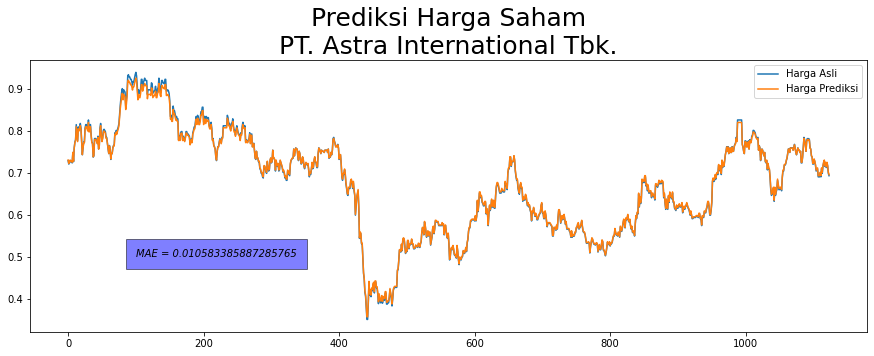

In [ ]:
plt.figure(figsize=(15,5))
y_pred = model.predict(X_test)
y_pred = list(np.reshape(y_pred, (1,len(y_pred)))[0])

X_test = np.reshape(X_test, (len(X_test),1))
X_test = list(np.reshape(X_test, (1,len(X_test)))[0])

plt.plot(X_test)
plt.plot(y_pred)
plt.legend(labels=['Harga Asli', 'Harga Prediksi'])
plt.text(100, 0.5, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
plt.title('Prediksi Harga Saham\nPT. Astra International Tbk.', fontsize=25)
plt.show()